# Run a Gene Ontology Enrichment Analysis (GOEA)

In [1]:
import sys
import pickle
print(sys.executable)
print(sys.path)
print(sys.version)

/home2/s418610/.conda/envs/py37_res_diffxpy/bin/python
['/home2/s418610/jupyter_notebooks/03.Invivo_neuronal_reprogramming/Manuscript/to_GitHub/GOEA', '', '/cm/shared/apps/cnvkit/0.9.5/lib/python3.6/site-packages', '/cm/shared/apps/python/3.6.4-anaconda/lib', '/cm/shared/apps/jupyterkernel-matlab/0.16.1/lib/python3.6/site-packages', '/cm/shared/apps/python/2.7.x-anaconda/lib', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python37.zip', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/lib-dynload', '/home2/s418610/.local/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages/fa2-0.3.5-py3.7-linux-x86_64.egg', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages/batchglm', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages/diffxpy', '/home2/s418610/.co

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import scanpy as sc
# import harmonypy as hm

In [3]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
# sc.settings.verbosity = 3

print('numpy', np.__version__)
print('pandas', pd.__version__)
# print('scipy', scipy.__version__)
# print('sklearn', sklearn.__version__)
print('statsmodels', sm.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)

# sc.logging.print_versions()

!date +%F

numpy 1.20.3
pandas 0.25.2
statsmodels 0.10.1
matplotlib 3.1.3
seaborn 0.9.0
2021-08-05


## 1. Download Ontologies and Associations

### 1a. Download Ontologies, if necessary

In [4]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

  EXISTS: go-basic.obo


### 1b. Download Associations, if necessary

In [5]:
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations()

  EXISTS: gene2go


## 2. Load Ontologies, Associations and Background gene set 

### 2a. Load Ontologies

In [6]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2020-09-10) 47,314 GO Terms


### 2b. Load Associations

In [7]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

In [8]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090]) # Taxid 10090 is Mus musculus

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:05.127204 383,293 annotations READ: gene2go 
1 taxids stored: 10090
BP 18,414 annotated mouse genes
MF 17,115 annotated mouse genes
CC 19,207 annotated mouse genes


### 2c. Load Background gene set
The background is all mouse protein-codinge genes

In [9]:
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as GeneID2nt_mus
# from goatools.test_data.genes_NCBI_10090_All import GENEID2NT as GeneID2nt_mus

In [10]:
len(GeneID2nt_mus.keys())

28212

## 3. Initialize a GOEA object
The GOEA object holds the Ontologies, Associations, and background.    

In [11]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_mus.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method



Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 62% 17,364 of 28,212 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 66% 18,550 of 28,212 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 59% 16,739 of 28,212 population items found in association


## 4. Read study genes
* Gene symbols from DE analysis need to be converted to gene IDs first

#### Making a reference dictionary to convert symbols of my genes to gene IDs

In [12]:
GeneID2Symbol_dict = {}

In [13]:
for GeneID in list(GeneID2nt_mus.keys()):
    Symbols = []
    Symbols.append(GeneID2nt_mus[GeneID].Symbol)
    if not GeneID2nt_mus[GeneID].Aliases == '':
        for alias in GeneID2nt_mus[GeneID].Aliases.split(','):
            Symbols.append(alias.strip())
    GeneID2Symbol_dict[GeneID] = Symbols

##### Example search of a gene symbol

In [14]:
gene_search = 'Ascl1'

In [15]:
for GeneID, names in GeneID2Symbol_dict.items():
    if gene_search in names:
        print(GeneID)

17172


#### Loading my genes and convert symbols to IDs

In [16]:
DE_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/Revision/DE_analysis/'

In [17]:
input_path = DE_dir + 'embryonic_neurogenesis_test_list_collection_100iter'
with open(input_path, 'rb') as input_file:
 
    test_list_collection = pickle.load(input_file)

In [18]:
assert len(test_list_collection) == 100

## 5. Run Gene Ontology Enrichment Analysis (GOEA)
You may choose to keep all results or just the significant results. In this example, we choose to keep only the significant results.

In [19]:
goea_collection_experiment = []
goea_collection_public = []

In [ ]:
# test_list_all = test_list_collection[0]
for iteration, test_list_all in enumerate(test_list_collection): 
    print('\n\n\n\n')
    print('Current iteration: ', iteration, '\n')

    #### Examine genes enriched in experimental cells

    #### Remove DEGs that are common to all clusters (see DE analysis jupyter notebook)

    #### For each iteration of DE analysis, run GOEA for one time
    
    goea_experiment_up_all = []
    for cluster, test_cluster in test_list_all:
        experiment_up_genes = test_cluster.summary()[np.logical_and(test_cluster.summary()['qval'] < 1e-2, test_cluster.summary()['log2fc'] > 1)]
        geneids_study = []
        # Remove commonly differentially expressed genes (see DE analysis jupyter notebook)
        for gene_search in experiment_up_genes['gene']:
            if gene_search in ['Lars2', 'Gm42418', 'AY036118']: # The 7's and 6's
                continue
            for GeneID, names in GeneID2Symbol_dict.items():
                if gene_search in names:
        #            print(GeneID)
                    geneids_study.append(GeneID)
                    break

        goea_results_all = goeaobj.run_study(geneids_study)
        # goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
        goea_experiment_up_all.append((cluster, experiment_up_genes, geneids_study, goea_results_all))


    #### Examine genes enriched in experimental cells

    #### Remove DEGs that are common to all clusters (see DE analysis jupyter notebook)

    #### For each iteration of DE analysis, run GOEA for one time

    goea_public_up_all = []
    for cluster, test_cluster in test_list_all:
        public_up_genes = test_cluster.summary()[np.logical_and(test_cluster.summary()['qval'] < 1e-2, test_cluster.summary()['log2fc'] < -1)]
        geneids_study = []
        # Remove commonly differentially expressed genes (see DE analysis jupyter notebook)
        for gene_search in public_up_genes['gene']:
            if gene_search in ['Rpl10', 'Rps27', 'Rps12', 'Rpl9', 'Rpl27']:
                continue
            for GeneID, names in GeneID2Symbol_dict.items():
                if gene_search in names:
        #            print(GeneID)
                    geneids_study.append(GeneID)
                    break

        goea_results_all = goeaobj.run_study(geneids_study)
        # goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    #    goea_public_up_all.append((cluster, public_up_genes, geneids_study, goea_results_sig))
        goea_public_up_all.append((cluster, public_up_genes, geneids_study, goea_results_all)) # Store all test results, as GO terms of interest might not always be significant 
                                                                                                # in all cell types

    # len(goea_public_up_all)
    goea_collection_experiment.append((iteration, goea_experiment_up_all))
    goea_collection_public.append((iteration, goea_public_up_all))






Current iteration:  0 


Run BP Gene Ontology Analysis: current study set of 164 IDs ...
 96%    157 of    164 study items found in association
100%    164 of    164 study items found in population(28212)
Calculating 12,357 uncorrected p-values using fisher_scipy_stats
  12,357 GO terms are associated with 17,364 of 28,212 population items
   1,291 GO terms are associated with    157 of    164 study items
  METHOD fdr_bh:
      21 GO terms found significant (< 0.05=alpha) ( 21 enriched +   0 purified): statsmodels fdr_bh
      91 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 164 IDs ...
 96%    158 of    164 study items found in association
100%    164 of    164 study items found in population(28212)
Calculating 1,745 uncorrected p-values using fisher_scipy_stats
   1,745 GO terms are associated with 18,550 of 28,212 population items
     234 GO terms

In [ ]:
assert len(goea_collection_experiment) == 100

In [ ]:
assert len(goea_collection_public) == 100

In [21]:
len(goea_collection_experiment)

63

In [22]:
len(goea_collection_public)

63

## 6. Plot enriched GO terms of interest as a function of reprogramming progression

#### Extracting results

In [24]:
del test_list_collection

In [25]:
goea_DF_collection_public = []
for iteration, goea_public_up_all in goea_collection_public:

    goea_DF_list_public = []
    for cluster, _, _, goea_results_sig in goea_public_up_all:

        goID = []
        goName = []
        goNamespace = []
        goEnrichment = []
        goAdjP = []
        study_count = []
        study_n = []
        pop_count = []
        pop_n = []
        for goea_result in goea_results_sig:
            goID.append(goea_result.goterm.id)
            goName.append(goea_result.goterm.name)
            goNamespace.append(goea_result.goterm.namespace)
            goEnrichment.append(goea_result.enrichment)
            goAdjP.append(goea_result.p_fdr_bh)
            study_count.append(goea_result.study_count)
            study_n.append(goea_result.study_n)
            pop_count.append(goea_result.pop_count)
            pop_n.append(goea_result.pop_n)

        goea_summary = pd.DataFrame(data={'goID': goID,
                                         'goName': goName, 
                                         'goNamespace': goNamespace, 
                                         'goEnrichment': goEnrichment, 
                                         'goAdjP': goAdjP, 
                                         'study_count': study_count, 
                                         'study_n': study_n, 
                                         'pop_count': pop_count, 
                                         'pop_n': pop_n})

        # goea_summary.sort_values(by='goAdjP', ascending=True, inplace=True)

        # goea_summary = goea_summary[goea_summary['goEnrichment']=='e']

        goea_summary_MF = goea_summary[goea_summary['goNamespace']=='molecular_function']
        goea_summary_BP = goea_summary[goea_summary['goNamespace']=='biological_process']
        goea_summary_CC = goea_summary[goea_summary['goNamespace']=='cellular_component']

        goea_DF_list_public.append((cluster, goea_summary_MF, goea_summary_BP, goea_summary_CC))
        
    goea_DF_collection_public.append((iteration, goea_DF_list_public))

In [26]:
len(goea_DF_collection_public)

63

In [27]:
goea_DF_collection_experiment = []
for iteration, goea_experiment_up_all in goea_collection_experiment:

    goea_DF_list_experiment = []
    for cluster, _, _, goea_results_sig in goea_experiment_up_all:

        goID = []
        goName = []
        goNamespace = []
        goEnrichment = []
        goAdjP = []
        study_count = []
        study_n = []
        pop_count = []
        pop_n = []
        for goea_result in goea_results_sig:
            goID.append(goea_result.goterm.id)
            goName.append(goea_result.goterm.name)
            goNamespace.append(goea_result.goterm.namespace)
            goEnrichment.append(goea_result.enrichment)
            goAdjP.append(goea_result.p_fdr_bh)
            study_count.append(goea_result.study_count)
            study_n.append(goea_result.study_n)
            pop_count.append(goea_result.pop_count)
            pop_n.append(goea_result.pop_n)

        goea_summary = pd.DataFrame(data={'goID': goID,
                                         'goName': goName, 
                                         'goNamespace': goNamespace, 
                                         'goEnrichment': goEnrichment, 
                                         'goAdjP': goAdjP, 
                                         'study_count': study_count, 
                                         'study_n': study_n, 
                                         'pop_count': pop_count, 
                                         'pop_n': pop_n})

        # goea_summary.sort_values(by='goAdjP', ascending=True, inplace=True)

        # goea_summary = goea_summary[goea_summary['goEnrichment']=='e']

        goea_summary_MF = goea_summary[goea_summary['goNamespace']=='molecular_function']
        goea_summary_BP = goea_summary[goea_summary['goNamespace']=='biological_process']
        goea_summary_CC = goea_summary[goea_summary['goNamespace']=='cellular_component']

        goea_DF_list_experiment.append((cluster, goea_summary_MF, goea_summary_BP, goea_summary_CC))
        
    goea_DF_collection_experiment.append((iteration, goea_DF_list_experiment))

In [28]:
len(goea_DF_collection_experiment)

63

##### Write and read data

In [29]:
GOEA_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/Revision/GOEA/'

In [30]:
# output_path = GOEA_dir + 'embryonic_neurogenesis_goea_DF_collection_public_100iter'
output_path = GOEA_dir + 'embryonic_neurogenesis_goea_DF_collection_public_63iter'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(goea_DF_collection_public, output_file)

In [31]:
# output_path = GOEA_dir + 'embryonic_neurogenesis_goea_DF_collection_experiment_100iter'
output_path = GOEA_dir + 'embryonic_neurogenesis_goea_DF_collection_experiment_63iter'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(goea_DF_collection_experiment, output_file)

In [5]:
input_path = int_out_dir + 'goea_DF_collection_public_100iter'
with open(input_path, 'rb') as input_file:
 
    goea_DF_collection_public = pickle.load(input_file)

In [6]:
input_path = int_out_dir + 'goea_DF_collection_experiment_100iter'
with open(input_path, 'rb') as input_file:
 
    goea_DF_collection_experiment = pickle.load(input_file)

In [7]:
assert len(goea_DF_collection_public)==100

In [8]:
assert len(goea_DF_collection_experiment)==100

#### Plot GO terms of interest

In [9]:
GOterm_list = ['cell cycle', 'defense response to virus']

In [41]:
GOterm_list = ['defense response to virus', 'immune system process', 'cellular response to interferon-beta']

In [44]:
GOterm_list = ['oxidation-reduction process', 
              'tricarboxylic acid cycle', 'oxidative phosphorylation', 'glycolytic process', 
              'ATP synthesis coupled proton transport', 'electron transport chain']

In [46]:
GOterm_list = ['lipid metabolic process', 'cellular lipid catabolic process', 'cell adhesion']

In [48]:
GOterm_list = ['cell cycle', 'ribosome biogenesis', 'translation', 
               'mitochondrial translation', 'mRNA processing', 
              'rRNA processing']

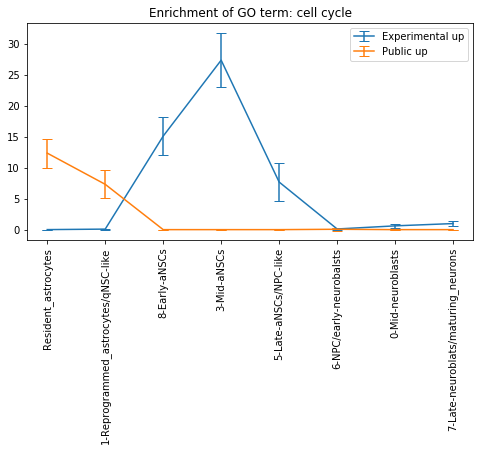

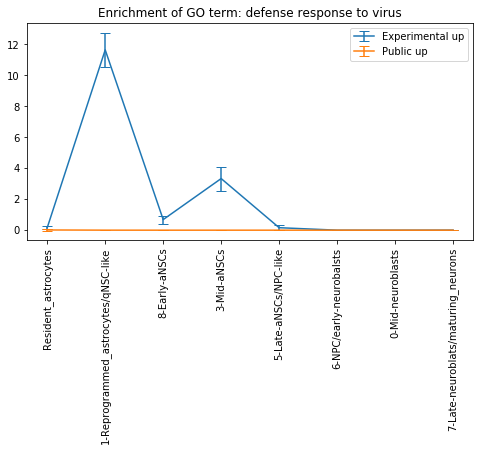

In [10]:
# Figure 3E, mid and bottom
for GOterm_oi in GOterm_list: 
    iteration, goea_DF_list_experiment = goea_DF_collection_experiment[0]
    data_experimental_up = {}
    for cluster, _, _, _ in goea_DF_list_experiment:
        data_experimental_up[cluster] = []

    for iteration, goea_DF_list_experiment in goea_DF_collection_experiment:
        for cluster, goea_summary_MF, goea_summary_BP, goea_summary_CC in goea_DF_list_experiment:
            data_experimental_up[cluster].append(goea_summary_BP.iloc[np.where(goea_summary_BP['goName']==GOterm_oi)[0][0],:]['goAdjP'])

    df_experimental_up = pd.DataFrame(data_experimental_up)

    df_experimental_up = df_experimental_up.T

    df_experimental_up = -np.log10(df_experimental_up)

    df_experimental_up['mean'] = df_experimental_up.mean(axis=1)

    df_experimental_up['std'] = df_experimental_up.std(axis=1)


    iteration, goea_DF_list_public = goea_DF_collection_public[0]
    data_public_up = {}
    for cluster, _, _, _ in goea_DF_list_public:
        data_public_up[cluster] = []

    for iteration, goea_DF_list_public in goea_DF_collection_public:
        for cluster, goea_summary_MF, goea_summary_BP, goea_summary_CC in goea_DF_list_public:
            data_public_up[cluster].append(goea_summary_BP.iloc[np.where(goea_summary_BP['goName']==GOterm_oi)[0][0],:]['goAdjP'])

    df_public_up = pd.DataFrame(data_public_up)

    df_public_up = df_public_up.T

    df_public_up = -np.log10(df_public_up)

    df_public_up['mean'] = df_public_up.mean(axis=1)

    df_public_up['std'] = df_public_up.std(axis=1)


#    row_order = ['Resident_astrocytes', '1-Reprogrammed_astrocytes/qNSC-like', '8-Early-aNSCs', 
#                '3-Mid-aNSCs', '5-Late-aNSCs/NPC-like', '6-NPC/early-neurobalsts', 
#                '0-Mid-neuroblasts', '7-Late-neuroblats/maturing_neurons']
    
    row_order = ['Resident astrocytes', 'Lenti-astrocytes', 'Early NPCs', 
            'Mid NPCs', 'Late NPCs', 'Early neuroblasts', 
            'Mid neuroblasts', 'Late neuroblasts']

    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(row_order))

    y_experimental_up = df_experimental_up.loc[row_order]['mean']
    error_experimental_up = df_experimental_up.loc[row_order]['std']

    y_public_up = df_public_up.loc[row_order]['mean']
    error_public_up = df_public_up.loc[row_order]['std']

    plt.errorbar(x, y_experimental_up, error_experimental_up/2, capsize=5)
    plt.errorbar(x, y_public_up, error_public_up/2, capsize=5)

    plt.xticks(x, row_order, rotation=90)
    plt.legend(['Experimental up', 'Public up'], loc='best')

    plt.title('Enrichment of GO term: '+GOterm_oi)

#    plt.savefig('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/99.Manuscript/Figures_v2/Figure1/linechart_'+GOterm_oi+'_DEGs.pdf')
    plt.show()